In [1]:
from logisticRegression import LogisticRegression, Optimizer
from scipy.io.arff import loadarff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

C:\Users\prusak.patryk\AppData\Local\Temp\ipykernel_2644\4281822120.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def addInteractions(X):
    newX=X
    for i in range(X.shape[1]):
        for j in range(i+1,X.shape[1]):
            newX=np.c_[newX,np.multiply(X[:,i],X[:,j])]
    return newX

1. Add a stopping rule
2. Perform tests for max 500 iterations (unless it converges earlier), use balanced accuracy (so do some train test splits, at least 5)
3. Check how the log likelihood value depends on iterations for each algorithm for train data
4. Compare the algorithms with 4 other existing solutions such as: LDA (Linear Discriminant analysis), QDA (Quadratic
Discriminant Analysis), Decision tree and Random Forest
5. In the case of small datasets, please compare the two versions of the logistic regression: model
without interactions and model with interactions.

1. Stopping rule: If the differences in loss function are smaller than 0.0001, stop.

In [3]:
# # This is just an overall idea, feel free to delete it all or modify or whatever :)
# # I'm wondering if this way of keeping results is optimal for later generating graphs from them
# # Currently it's just the result, name of the classifier, and split, seed
# # hmm cause for the accuracies we will probably want to draw boxplots, so like on the y axis accuracy, on the x axis train test split and then for each train test split a boxplot for each type of classifier
# # I guess it should be possible with sns, maybe by setting y to accuracy, x to split and hue by classifier type or smth like that
# # For the plots of loss function, I'm not sure how to represent it, whether to compute the mean for each iteration and plot a line going through those points
# # or to just take a single result and plot that
def performExperiment(X,y,logisticparams):
    costs=[]
    accuracies=[]
    splits = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    # splits = [0.5]
    seeds = [42,123,0,321,9]
    # seeds = [42]
    classifiersNames = ['Linear Discriminant Analysis','Quadratic Discriminant Analysis', 'Decision Tree Classifier', 'Random Forest Classifier']
    classifiers = [LinearDiscriminantAnalysis(),QuadraticDiscriminantAnalysis(),DecisionTreeClassifier(random_state=42),RandomForestClassifier(random_state=42)]
    for split in splits:
        for seed in seeds:
            np.random.seed(seed)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=seed)
            print("\nExperiment: split: "+str(split)+" seed: "+str(seed))
            for logisticparam in logisticparams:
                logisticRegressor = LogisticRegression(learningRate=logisticparam['learningRate'],noOfIterations=500, optimizer=logisticparam['optimizer'])
                cost = logisticRegressor.fit(X_train.astype(float),y_train.astype(float))
                y_pred=logisticRegressor.predict(X_test)
                costs.append([cost,logisticparam['optimizer'],seed,split])
                accuracies.append([1-np.sum(np.abs(y_pred-y_test))/len(y_test),logisticparam['optimizer'],seed,split])
            for i,classifier in enumerate(classifiers):
                history = classifier.fit(X_train.astype(float),y_train.astype(float))
                y_pred=classifier.predict(X_test)
                costs.append([history, classifiersNames[i],seed,split])
                accuracies.append([1-np.sum(np.abs(y_pred-y_test))/len(y_test),classifiersNames[i],seed,split])
    # We could then produce some graphs and means from those results
    return costs, accuracies
    

In [4]:
# Loading the dataset
raw_data = loadarff("./Datasets/blood-transfusion-service-center.arff")
df_data = pd.DataFrame(raw_data[0])
df_no_class=df_data.drop('Class',axis=1)

# Removing highly correlated features
corr = df_no_class.corr()
mask = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.9).any()
df_blood_no_class = df_no_class.loc[:, mask]



X = df_blood_no_class.to_numpy()

y = df_data['Class'].to_numpy()
y[y==b'2']=1
y[y==b'1']=0

costs,accuracies = performExperiment(X,y,[{'learningRate':0.001, 'optimizer':Optimizer.IWLS},{'learningRate':0.001, 'optimizer':Optimizer.Adam},{'learningRate':0.000001, 'optimizer':Optimizer.SGD}])


Experiment: split: 0.1 seed: 42
IWLS Converged after 5 iterations
Adam Converged after 313 iterations
SGD Converged after 226 iterations

Experiment: split: 0.1 seed: 123
IWLS Converged after 6 iterations
Adam Converged after 333 iterations
SGD Converged after 176 iterations

Experiment: split: 0.1 seed: 0
IWLS Converged after 6 iterations
Adam Converged after 323 iterations
SGD Converged after 254 iterations

Experiment: split: 0.1 seed: 321
IWLS Converged after 5 iterations
Adam Converged after 315 iterations
SGD Converged after 292 iterations

Experiment: split: 0.1 seed: 9
IWLS Converged after 5 iterations
Adam Converged after 312 iterations
SGD Converged after 217 iterations

Experiment: split: 0.2 seed: 42
IWLS Converged after 5 iterations
Adam Converged after 316 iterations
SGD Converged after 300 iterations

Experiment: split: 0.2 seed: 123
IWLS Converged after 6 iterations
Adam Converged after 329 iterations
SGD Converged after 234 iterations

Experiment: split: 0.2 seed: 0
I

In [2]:
# Loading the dataset
raw_blood_data = loadarff("./Datasets/blood-transfusion-service-center.arff")
df_blood_data = pd.DataFrame(raw_blood_data[0])

# Separating other features from target
df_blood_no_class = df_blood_data.drop('Class', axis=1)

# Removing highly correlated features
corr = df_blood_no_class.corr()
mask = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.9).any()
df_blood_no_class = df_blood_no_class.loc[:, mask]

# Creating X and Y
X_blood = df_blood_no_class
y_blood = df_blood_data['Class'].astype(int)


In [5]:
def compute_accuracies(X, y, splits=[0.1, 0.2, 0.3, 0.4, 0.5], seeds=[0, 42, 123, 321, 9]):
    # For Logistic Regression with Adam optimizer
    balanced_accuracies_adam_log_reg = []
    accuracies_adam_log_reg = []
    costs_adam_log_reg = []

    # For Logistic Regression with SGD optimizer
    balanced_accuracies_sgd_log_reg = []
    accuracies_sgd_log_reg = []
    costs_sgd_log_reg = []

    # For Logistic Regression with IWLS optimizer
    balanced_accuracies_iwls_log_reg = []
    accuracies_iwls_log_reg = []
    costs_iwls_log_reg = []

    # For LAD (Least Absolute Deviations) Regression
    balanced_accuracies_lad = []
    accuracies_lad = []
    costs_lad = []

    # For QAD (Quantile Absolute Deviations) Regression
    balanced_accuracies_qad = []
    accuracies_qad = []
    costs_qad = []

    # For Decision Tree Classifier
    balanced_accuracies_dec_tree = []
    accuracies_dec_tree = []
    costs_dec_tree = []

    # For Random Forest Classifier
    balanced_accuracies_rand_forest = []
    accuracies_rand_forest = []
    costs_rand_forest = []

    costs = {}
    balanced_accuracies = {}
    accuracies = {}
    
    adam = Optimizer.Adam
    sgd = Optimizer.SGD
    iwls = Optimizer.IWLS
    
    # Initialize lists for each classifier
    classifiers = {
        "Adam_Log_Reg": (accuracies_adam_log_reg, balanced_accuracies_adam_log_reg, costs_adam_log_reg, LogisticRegression(learningRate=0.001, noOfIterations=500, optimizer=adam)),
        # "SGD_Log_Reg": (accuracies_sgd_log_reg, balanced_accuracies_sgd_log_reg, costs_sgd_log_reg, LogisticRegression(learningRate=0.001, noOfIterations=500, optimizer=sgd)),
        # "IWLS_Log_Reg": (accuracies_iwls_log_reg, balanced_accuracies_iwls_log_reg, costs_iwls_log_reg, LogisticRegression(learningRate=0.001, noOfIterations=500, optimizer=iwls)),
        "LAD": (accuracies_lad, balanced_accuracies_lad, costs_lad, LinearDiscriminantAnalysis()),
        "QAD": (accuracies_qad, balanced_accuracies_qad, costs_qad, QuadraticDiscriminantAnalysis()),
        "Decision_Tree": (accuracies_dec_tree, balanced_accuracies_dec_tree, costs_dec_tree, DecisionTreeClassifier()),
        "Random_Forest": (accuracies_rand_forest, balanced_accuracies_rand_forest, costs_rand_forest, RandomForestClassifier())
    }

    for clf_name, (accuracy_list, balanced_accuracy_list, costs_list, clf) in classifiers.items():
        accuracies[clf_name] = {}
        balanced_accuracies[clf_name] = {}
        costs[clf_name] = {}

        for split in splits:
            for seed in seeds:
                np.random.seed(seed)
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=seed)

                cost = clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)

                accuracy = accuracy_score(y_test, y_pred)
                balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
                
                accuracy_list.append(accuracy)
                balanced_accuracy_list.append(balanced_accuracy)
                costs_list.append(cost)

                accuracies[clf_name][(split, seed)] = accuracy
                balanced_accuracies[clf_name][(split, seed)] = balanced_accuracy
                costs[clf_name][(split, seed)] = cost

    return accuracies, balanced_accuracies, costs

In [6]:
accuracy, balanced_accuracy, costs = compute_accuracies(X_blood, y_blood)

/Users/salveendutt/GithubRepos/advml-proj-1/logisticRegression.py:97: RuntimeWarning: divide by zero encountered in log
  self.costs.append((-1.0/X.shape[0])*(np.dot(y,np.log(yHat))+np.dot((1.0-y),np.log(1.0-yHat))))
/Users/salveendutt/GithubRepos/advml-proj-1/logisticRegression.py:97: RuntimeWarning: divide by zero encountered in log
  self.costs.append((-1.0/X.shape[0])*(np.dot(y,np.log(yHat))+np.dot((1.0-y),np.log(1.0-yHat))))
/Users/salveendutt/GithubRepos/advml-proj-1/logisticRegression.py:97: RuntimeWarning: divide by zero encountered in log
  self.costs.append((-1.0/X.shape[0])*(np.dot(y,np.log(yHat))+np.dot((1.0-y),np.log(1.0-yHat))))
/Users/salveendutt/GithubRepos/advml-proj-1/logisticRegression.py:97: RuntimeWarning: divide by zero encountered in log
  self.costs.append((-1.0/X.shape[0])*(np.dot(y,np.log(yHat))+np.dot((1.0-y),np.log(1.0-yHat))))
/Users/salveendutt/GithubRepos/advml-proj-1/logisticRegression.py:97: RuntimeWarning: divide by zero encountered in log
  self.costs

In [9]:
# Print accuracy
print("Accuracy:")
for clf_name, acc_dict in accuracy.items():
    print(f"{clf_name}:")
    for key, value in acc_dict.items():
        print(f"  Split: {key[0]}, Seed: {key[1]}, Accuracy: {value}")
    print(f"  Mean Accuracy: {np.mean(list(acc_dict.values()))}\n")

# Print balanced_accuracy
print("Balanced Accuracy:")
for clf_name, b_acc_dict in balanced_accuracy.items():
    print(f"{clf_name}:")
    for key, value in b_acc_dict.items():
        print(f"  Split: {key[0]}, Seed: {key[1]}, Balanced Accuracy: {value}")
    print(f"  Mean Balanced Accuracy: {np.mean(list(b_acc_dict.values()))}\n")

# Print costs
print("Costs:")
for clf_name, cost_dict in costs.items():
    print(f"{clf_name}:")
    for key, value in cost_dict.items():
        print(f"  Split: {key[0]}, Seed: {key[1]}, Cost: {value}")

Accuracy:
Adam_Log_Reg:
  Split: 0.1, Seed: 0, Accuracy: 0.6666666666666666
  Split: 0.1, Seed: 42, Accuracy: 0.8
  Split: 0.1, Seed: 123, Accuracy: 0.6933333333333334
  Split: 0.1, Seed: 321, Accuracy: 0.8
  Split: 0.1, Seed: 9, Accuracy: 0.72
  Split: 0.2, Seed: 0, Accuracy: 0.7266666666666667
  Split: 0.2, Seed: 42, Accuracy: 0.7533333333333333
  Split: 0.2, Seed: 123, Accuracy: 0.7333333333333333
  Split: 0.2, Seed: 321, Accuracy: 0.8266666666666667
  Split: 0.2, Seed: 9, Accuracy: 0.7466666666666667
  Split: 0.3, Seed: 0, Accuracy: 0.7288888888888889
  Split: 0.3, Seed: 42, Accuracy: 0.7333333333333333
  Split: 0.3, Seed: 123, Accuracy: 0.7333333333333333
  Split: 0.3, Seed: 321, Accuracy: 0.8044444444444444
  Split: 0.3, Seed: 9, Accuracy: 0.7155555555555555
  Split: 0.4, Seed: 0, Accuracy: 0.7533333333333333
  Split: 0.4, Seed: 42, Accuracy: 0.7366666666666667
  Split: 0.4, Seed: 123, Accuracy: 0.7233333333333334
  Split: 0.4, Seed: 321, Accuracy: 0.7933333333333333
  Split: 0.4

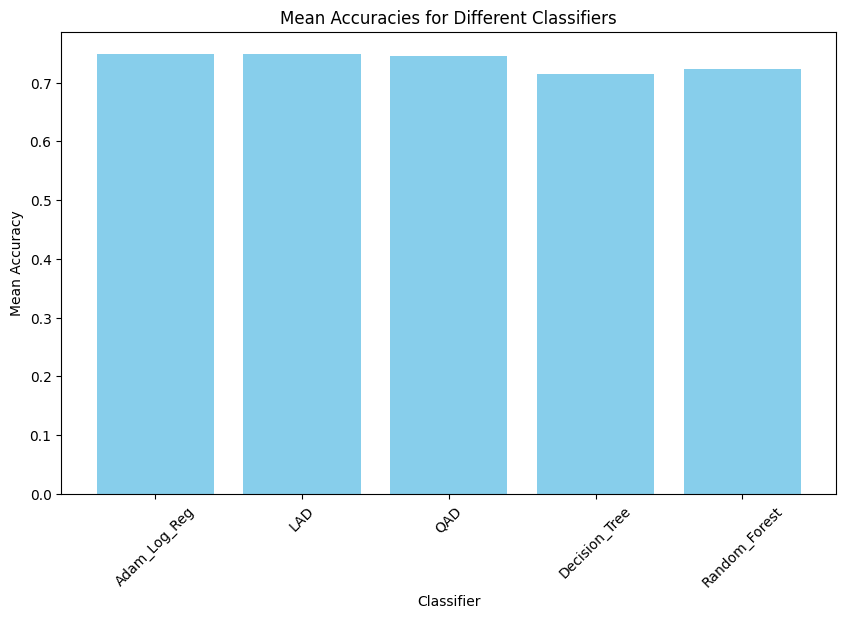

In [10]:
mean_accuracies = {clf_name: np.mean(list(acc_dict.values())) for clf_name, acc_dict in accuracy.items()}
plt.figure(figsize=(10, 6))
plt.bar(mean_accuracies.keys(), mean_accuracies.values(), color='skyblue')
plt.title('Mean Accuracies for Different Classifiers')
plt.xlabel('Classifier')
plt.ylabel('Mean Accuracy')
plt.xticks(rotation=45)
plt.show()

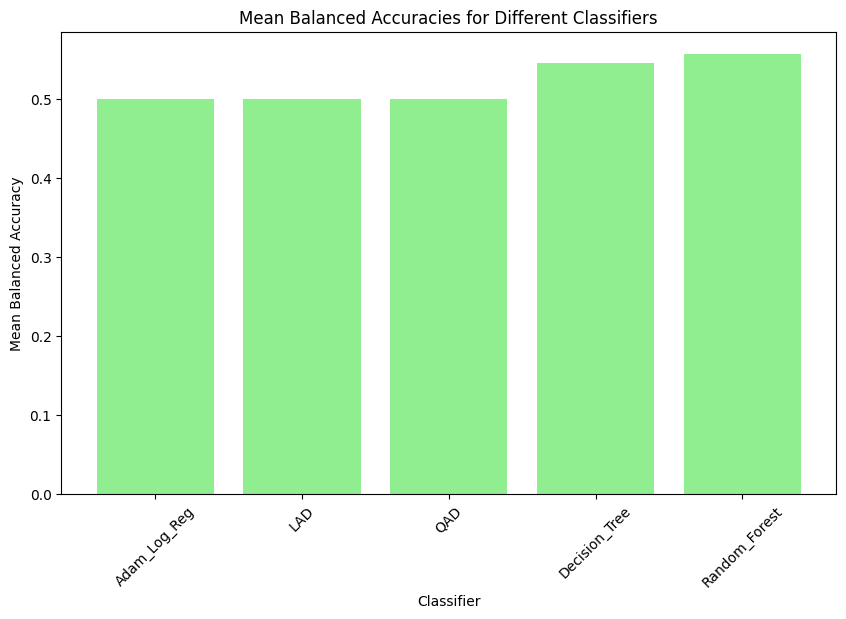

In [11]:
mean_balanced_accuracies = {clf_name: np.mean(list(b_acc_dict.values())) for clf_name, b_acc_dict in balanced_accuracy.items()}
plt.figure(figsize=(10, 6))
plt.bar(mean_balanced_accuracies.keys(), mean_balanced_accuracies.values(), color='lightgreen')
plt.title('Mean Balanced Accuracies for Different Classifiers')
plt.xlabel('Classifier')
plt.ylabel('Mean Balanced Accuracy')
plt.xticks(rotation=45)
plt.show()